In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geemap import ml
from sklearn import ensemble

import geemap, ee

import warnings
warnings.filterwarnings("ignore")

In [34]:
import sys  
sys.path.insert(0, '../lib/')
import sand_classification as sc
import quality_mosaic as qm

In [35]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [36]:
#open the excel file 'data/labels/gt-bands.xlsx' and combine all the sheets into one dataframe
df = pd.read_excel('../data/labels/gt-bands.xlsx', sheet_name=None)
df = pd.concat(df, ignore_index=True)
df

,Unnamed: 0,ID,Latitude,Longitude,Class,Date,Site,ATT ID,ImageName,Name,...,keep,location_tweaked,class_code,Country,Notes,Notes on how these were chosen,D50,D90,Distance Downstram of MFT (km),D84
0,0.0,sedinet-0,17.973859,-65.988747,sand,2020-06-18,Coastal,1,ATT1_Sediment_Playa_Villa_Pesquera_Patillas_Pu...,PR001,...,False,False,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,sedinet-1,18.459221,-65.987196,sand,2020-06-15,Coastal,2,ATT2_20200531_151022.jpg,PR002,...,True,True,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,sedinet-2,38.665018,-75.067643,sand,2020-06-22,Coastal,4,ATT4_2471FF73-CE00-470D-97F8-9F4169EF5546.jpeg,DSS Fordune,...,True,True,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,sedinet-3,38.665267,-75.067228,sand,2020-06-22,Coastal,5,ATT5_C7809DDB-E022-45EA-9559-EA3F86F35B4B.jpeg,DSS berm/beach,...,True,True,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,sedinet-4,38.665184,-75.066829,sand,2020-06-22,Coastal,6,ATT6_B803E195-0A46-4D78-9D45-CA9AEC58E277.jpeg,DSS Swash,...,False,False,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,NaN,ns-17,21.969749,89.178629,water,2021-10-31,Sundarbans,NaN,NaN,NaN,...,True,False,4,Bangladesh,Water is sediment filled,NaN,NaN,NaN,NaN,NaN
130,NaN,ns-18,9.978316,76.252207,bare,2022-12-11,Cochin Docks,NaN,NaN,NaN,...,True,False,5,India,Kerala,NaN,NaN,NaN,NaN,NaN
131,NaN,ns-19,9.975609,76.255231,water,2022-12-11,Cochin Bay,NaN,NaN,NaN,...,True,False,4,India,Kerala,NaN,NaN,NaN,NaN,NaN
132,NaN,ns-20,41.019946,28.973160,bare,2021-12-11,Instanbul bridge,NaN,NaN,NaN,...,True,False,5,Turkey,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
display(df.columns)
keeper_columns = ['ID', 'class_code', 'B2_mean', 'B3_mean', 'B4_mean', 'B8_mean',
       'B8A_mean', 'B11_mean', 'B12_mean', 'VV_mean', 'VH_mean', 'mTGSI_mean',
       'BSI_mean', 'NDWI_mean', 'keep','Latitude','Longitude']

plotting_columns = ['ID', 'Class', 'Latitude','Longitude']


Index(['Unnamed: 0', 'ID', 'Latitude', 'Longitude', 'Class', 'Date', 'Site',
       'ATT ID', 'ImageName', 'Name', 'Coin', 'd10', 'd16', 'd25', 'd50',
       'd65', 'd75', 'd84', 'd90', 'mean', 'location', 'City', 'FM', 'r2_fm',
       'stderr_fm', 'FM_class', 'D75', 'D4_75', 'D_075', 'r2_grid',
       'stderr_grid', 'Source', 'B2_mean', 'B3_mean', 'B4_mean', 'B8_mean',
       'B8A_mean', 'B11_mean', 'B12_mean', 'VV_mean', 'VH_mean', 'mTGSI_mean',
       'BSI_mean', 'NDWI_mean', 'keep', 'location_tweaked', 'class_code',
       'Country', 'Notes', 'Notes on how these were chosen', 'D50', 'D90',
       'Distance Downstram of MFT (km)', 'D84'],
      dtype='object')

In [38]:
#set the type of 'keep' columns to boolean
df['keep'] = df['keep'].astype(bool)
#check if the column 'ID' is unique
df['ID'].is_unique

True

In [39]:
labels = df[keeper_columns]
labels = labels[labels['keep'] == True].reset_index(drop=True)

#check if there are any null values
labels.isnull().sum()

ID            0
class_code    0
B2_mean       0
B3_mean       0
B4_mean       0
B8_mean       0
B8A_mean      0
B11_mean      0
B12_mean      0
VV_mean       0
VH_mean       0
mTGSI_mean    0
BSI_mean      0
NDWI_mean     0
keep          0
Latitude      0
Longitude     0
dtype: int64

In [40]:
labels

,ID,class_code,B2_mean,B3_mean,B4_mean,B8_mean,B8A_mean,B11_mean,B12_mean,VV_mean,VH_mean,mTGSI_mean,BSI_mean,NDWI_mean,keep,Latitude,Longitude
0,sedinet-1,1,1909.959839,2408.223389,2711.885498,3095.604492,3023.788086,2754.255127,2127.833740,-12.245424,-19.858164,-0.011403,0.046433,-0.133137,True,18.459221,-65.987196
1,sedinet-2,1,2296.496094,2880.759766,3350.108643,4453.658691,4434.116211,5267.705566,5056.720703,-15.439523,-21.776503,0.089654,0.120402,-0.217234,True,38.665018,-75.067643
2,sedinet-3,1,2691.572021,3383.153076,4000.680176,4829.711914,4851.709473,6080.360352,6131.175781,-18.035833,-26.745705,0.124123,0.145531,-0.176357,True,38.665267,-75.067228
3,sedinet-5,1,3196.637695,3728.590576,4162.385742,4965.102539,5022.440918,5703.236328,5773.673340,-17.205423,-24.548832,0.080977,0.094375,-0.141128,True,39.792640,-74.093250
4,sedinet-6,1,3171.919922,3666.031982,4147.919922,4890.768066,4860.855957,5720.423828,5889.215820,-15.189863,-23.240173,0.090201,0.100478,-0.143360,True,39.792648,-74.092864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,ns-17,4,870.122803,1095.929810,1060.596436,970.807007,952.868408,289.307007,160.912277,-18.204535,-24.624493,-0.148715,-0.153062,0.065929,True,21.969749,89.178629
113,ns-18,5,1358.083008,1590.857178,1731.253418,1777.852539,1843.774170,1959.027710,1801.608276,-7.064449,-13.419824,0.048165,0.081212,-0.054851,True,9.978316,76.252207
114,ns-19,4,489.859375,571.312500,380.609375,138.546875,121.046875,60.656250,42.906250,-20.244843,-28.267944,-0.126171,-0.174898,0.609784,True,9.975609,76.255231
115,ns-20,5,745.926575,743.293762,780.807922,795.406799,751.265564,697.581909,659.079102,-2.869668,-12.569727,-0.025577,-0.018996,-0.032109,True,41.019946,28.973160


<AxesSubplot:xlabel='class_code', ylabel='count'>

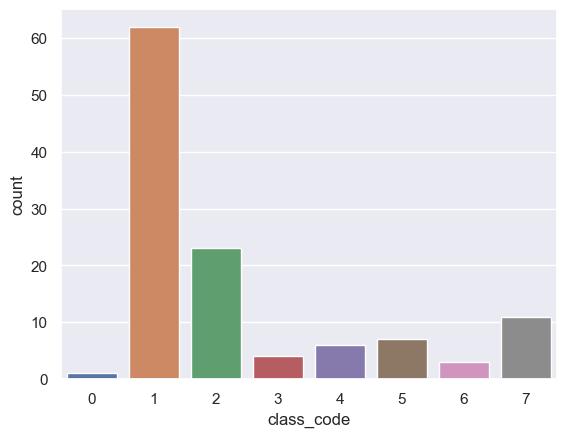

In [41]:
#Using seaborn plot the distribution of each class_code
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(x="class_code", data=labels)


# Train a model using GEE's RF

In [14]:
def train_classifier(df, type='sklearn', output_type=None, n_estimators=100, max_depth=10):
    """
    Train a classifier using the specified type.
    :param df: A pandas dataframe containing the training data. It must contain all the bands of interest, latitude, logitude and class_code.
    :param type: The type of classifier to train. Valid values are 'sklearn' and 'gee'.
    :param n_estimators: The number of trees in the forest
    :param max_depth: The maximum depth of the tree
    Returns: tuple containing:
        A trained GEE classifier.
        trees: string list of trees in the forest so it can be saved later
    """

    random_state = 13

    if type == 'sklearn':
        label = 'class_code'
        features = qm.OBIA_BANDS

        # get the features and labels into separate variables
        X = df[features]
        y = df[label]

        rf = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state).fit(X, y)
        #Now convert to GEE classifier
        trees = ml.rf_to_strings(rf, features)
        assert(len(trees) == n_estimators)
        classifier = ml.strings_to_classifier(trees)
        if output_type == 'Prob':
            classifier = classifier.setOutputMode('MULTIPROBABILITY')

        
    elif type == 'gee':
        # get the features and labels into separate variables
        X = geemap.common.pandas_to_ee(df[qm.FC_columns], 'Longitude', 'Latitude')

        if output_type == 'Prob':
            classifier = ee.Classifier.smileRandomForest(n_estimators, seed=random_state).setOutputMode('MULTIPROBABILITY').train(X, 'class_code', qm.OBIA_BANDS)
        else:
            classifier = ee.Classifier.smileRandomForest(n_estimators, seed=random_state).train(X, 'class_code', qm.OBIA_BANDS)
    
        trees = ee.List(ee.Dictionary(classifier.explain()).get('trees')).getInfo()
    else:
        raise Exception('Invalid classifier type: {}'.format(type))


    return classifier, trees



In [12]:
#normalize each column in X to keep values between 0 and 1
# X = (X - X.min()) / (X.max() - X.min())
# X

## Fit the classifier

In [46]:
# RF, trees = train_classifier(labels, type='sklearn', n_estimators=200, max_depth=10) #,output_type='Prob')
RF, trees = train_classifier(labels, type='gee', n_estimators=200, max_depth=10)#, output_type='Prob')

In [31]:
RF.getInfo()

{'type': 'Classifier.decisionTreeEnsemble',
 'treeStrings': ['1) root 71 9999 9999 (7.946961899027693)\n  2) VV_mean <= -14.058002 71 0.6656 0\n    4) mTGSI_mean <= -0.089638 48 0.5224 0\n      8) B2_mean <= 2136.546509 4 0.0000 3 *\n      9) B2_mean > 2136.546509 3 0.0000 2 *\n    5) mTGSI_mean > -0.089638 48 0.5224 0\n      10) VV_mean <= -16.935803 17 0.0000 0 *\n      11) VV_mean > -16.935803 41 0.3545 0\n        22) B11_mean <= 4063.667969 24 0.5181 0\n          44) mTGSI_mean <= 0.061081 16 0.6272 0\n            88) B3_mean <= 2227.836182 5 0.0000 0 *\n            89) B3_mean > 2227.836182 1 0.0000 2 *\n          45) mTGSI_mean > 0.061081 16 0.6272 0\n            90) VH_mean <= -25.828629 10 0.5312 1\n              180) BSI_mean <= 0.105509 2 0.0000 1 *\n              181) BSI_mean > 0.105509 2 0.0000 0 *\n            91) VH_mean > -25.828629 10 0.5312 1\n              182) B8A_mean <= 3206.428589 5 0.0000 1 *\n              183) B8A_mean > 3206.428589 1 0.0000 4 *\n        23) B

### Save RF Classifier to EE Asset

In [23]:
def save_trees_gee(trees, asset_name):
    """
    Save the trees to a GEE asset
    :param trees: list of trees
    :param asset_id: GEE asset id
    """
    # convert the list of trees to a string
    asset_id =  f"projects/gee-sand/assets/{asset_name}"
    display(asset_id)
    ml.export_trees_to_fc(trees, asset_id)


In [ ]:
save_trees_gee(trees, 'RF_200_10')

# Classify

In [24]:
# center for AOI
lon, lat = 84.2047028760486,24.90192702360151 #Dehri-on-Sone
# lat, lon =  28.773532,  80.125429 #Sharda GST - DIngle 2016
lat, lon =  29.102294,  80.142014 #Sharda-0
# lat, lon = -23.856882,  35.548001 #Tofo
lat, lon = -34.17182579028969, 24.641000758380677 #Oyster Bay
lat, lon = 28.631691, 81.277637 #Karnali-4
roi_buffer_m = 5000

date = '2022-05-09'
max_search_window_months = 3
median_samples = 5
mosaic_method = 'median' #'qm'

In [25]:
point = ee.Geometry.Point([lon, lat])
roi = point.buffer(roi_buffer_m).bounds()


s1_s2 = qm.get_s1_s2(roi=roi, date=date, max_search_window_months=max_search_window_months,median_samples=median_samples, mosaic_method=mosaic_method, clip=False)
s1_s2.bandNames()

Search window from 2022-02-09 to 2022-08-09


In [47]:
Map = geemap.Map()
Map.centerObject(point, 14)
Map.add_basemap('SATELLITE')
Map.addLayer(s1_s2, qm.visParamsVV, 'S1', False)
Map.addLayer(s1_s2, qm.visParamsMTGSI , 'mTGSI')
Map.addLayer(s1_s2, qm.visParamsRGB, 'S2')
Map

Map(center=[28.631691000000004, 81.277637], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

In [48]:
size_segmentation = 10

# Segmentation using a SNIC approach based on the dataset previosly generated
seeds = ee.Algorithms.Image.Segmentation.seedGrid(size_segmentation); #to get spaced grid notes at a distance specified by segmentation size parameter
snic = ee.Algorithms.Image.Segmentation.SNIC(
  image = s1_s2, #our multi-band image with selected bands same as for pixel-based
  compactness = 0,  #allow flexibility in object shape, no need to force compactness
  connectivity = 8, #use all 8 neighboring pixels in a pixel neighborhood
  neighborhoodSize = 256,
  seeds = seeds
)
vizParamsSNIC = {'bands': ['B4_mean','B3_mean','B11_mean'], 'min': 0, 'max': 3000}
Map.addLayer(snic, vizParamsSNIC,'SNIC', False)


#To visualize snic result:
Map.addLayer(snic.randomVisualizer(), None, 'Clusters', False)

#The next step generates a list of band names from the snic image, but without "clusters"
#since we don't need to use pixel values of their cluster IDs as a basis for class mapping:
predictionBands=snic.bandNames().remove("clusters")
# predictionBands.getInfo()

In [49]:
palette = ['008080','f3ff4a','ffa500','ff00ff', '2E86C1','8c411d','00854d','551a4d']

classy_visParams = {
    'min': 0,
    'max': 4000,
    'palette': palette,
}

classy_RF = snic.select(predictionBands).classify(RF)
#necessary to keep the final resolution at 10m: not needed if you're zooming around and using interactively
# classy_RF = classy_RF.reproject (crs = classy_RF.projection (), scale = 10)

# classy_RF.getInfo()

Map.addLayer(
    classy_RF,
    {"min": 0, "max": len(qm.class_dict)-1, "palette": palette},
    'classification',
)

Map.add_legend(legend_title="Classes", legend_dict=qm.legend_dict, position="bottomleft")


In [50]:
palette_small = ['551a4d','f3ff4a','ffa500']
remapped_classy_RF = classy_RF.remap([0,1,2,3,4,5,6,7], [0,1,2,0,0,0,0,0])
Map.addLayer(remapped_classy_RF, {'min':0, 'max':2, "palette": palette_small},
             'Reduced Classes');

In [58]:
RF_multi = RF.setOutputMode('MULTIPROBABILITY')

classy_RF_multi = snic.select(predictionBands).classify(RF_multi)
# classy_RF_multi = classy_RF_multi.reproject (crs = classy_RF_multi.projection (), scale = 10)

classNameList = list(qm.legend_dict.keys())
rfresult_PROB = classy_RF_multi.arrayFlatten([classNameList])

remapped_classy_RF_multi = classy_RF_multi.remap([0,1,2,3,4,5,6,7], [0,1,2,0,0,0,0,0])

# Visualize only the sand layer (select numeric value corresponding with the class) 
Map.addLayer(rfresult_PROB.select(['sand','gravel','water']), {'min':0, 'max':1},
             'Tricolor')

bgnd_color = '808080'

Map.addLayer(rfresult_PROB.select(1), {'min':0, 'max':1, 'palette': [bgnd_color, 'ffff00']},
             'RF membership for sand')
Map.addLayer(rfresult_PROB.select(2), {'min':0, 'max':1, 'palette': [bgnd_color, 'ffa500']},
             'RF membership for gravel')
Map.addLayer(rfresult_PROB.select(7), {'min':0, 'max':1, 'palette': [bgnd_color, '551a4d']},
             'RF membership for other')
Map.addLayer(rfresult_PROB.select(4), {'min':0, 'max':1, 'palette': [bgnd_color, '2E86C1']},
             'RF membership for water')

In [57]:
remapped_classy_RF.bandNames().getInfo()

['remapped']